# Property Price By Country

## Import Libraries

In [115]:
import empiricaldist
import janitor
import matplotlib.pyplot as plt
import numpy as np
from numpy import hstack
import pandas as pd
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss
import scipy.stats
from sklearn.neighbors import KernelDensity
import missingno
import upsetplot

%run pandas-missing-extension.ipynb

In [116]:
%run pandas-missing-extension.ipynb

## Graphics Appearance

In [117]:
%matplotlib inline
sns.set_style(rc={'axes.facecolor':'#dddede'}, style = 'darkgrid')
sns.set_context(context='notebook')
plt.rcParams['figure.figsize'] = (9, 6)


continent_color = {
    'America': '#97DB4F',
    'Europe': '#0f7175ff',
    'Asia' :'#c65dc9ff',
    'Oceania':'#F9704E',
    'Africa': '#53d8fb'
}

Note that there is no standard formula to calculate property price indices. Our formulas differs from Case-Shiller Index, UK Housing Price Index, etc.

* **Price to Income Ratio** is the basic measure for apartment purchase affordability (lower is better).

    * Net disposable family income, as defined as 1.5 * the average net salary (50% is assumed percentage of women in the workforce)
    * Median apartment size is 90 square meters
    * Price per square meter (the formula uses) is the average price of square meter in the city center and outside of the city center

* **Gross Rental Yield** is the total yearly gross rent divided by the house price (expressed in percentages). Higher is better.

* **Price to Rent Ratio** is the average cost of ownership divided by the received rent income (if buying to let) or the estimated rent that would be paid if renting (if buying to reside). 
    * Lower values suggest that it is **better to buy** rather than rent, and higher values suggest that it is **better to rent** rather than buy. 
        * rent per square meter assumes 1 bedroom apt has 50 square meters and 3 bedroom apartment has 110 square meters. 
        * It doesn't take into account taxes or maintenance fees.


* **Mortgage as Percentage of Income** is a ratio of the actual monthly cost of the mortgage to take-home family income (lower is better). Average monthly salary is used to estimate family income. It assumes 100% mortgage is taken on 20 years for the house(or apt) of 90 square meters which price per square meter is the average of price in the city center and outside of city center.

* **Loan Affordability Index** is an inverse of mortgage as percentage of income. Used formula is : (100 / mortgage as percentage of income) (higher is better).

[Font](https://www.numbeo.com/property-investment/indicators_explained.jsp)

In [118]:
df_prop = pd.read_csv('bestCountry/property/property-2023-mid.csv')

In [119]:
df_prop.columns

Index(['Country', 'Price_to_Income', 'Gross_Rental_Ce', 'Gross_Rental_Out',
       'Price_Ratio_Ce', 'Price_Ratio_Out', 'Mortgage_As_Percentage',
       'Affordability'],
      dtype='object')

## Rename Columns

In [120]:
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 106 non-null    object 
 1   Price_to_Income         106 non-null    float64
 2   Gross_Rental_Ce         106 non-null    float64
 3   Gross_Rental_Out        106 non-null    float64
 4   Price_Ratio_Ce          106 non-null    float64
 5   Price_Ratio_Out         106 non-null    float64
 6   Mortgage_As_Percentage  106 non-null    float64
 7   Affordability           106 non-null    float64
dtypes: float64(7), object(1)
memory usage: 6.8+ KB


In [121]:
df_prop.describe()

,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,14.626415,5.031132,5.300943,24.468868,22.862264,168.037736,1.103774
std,11.312937,2.200838,2.259814,13.101656,11.950361,191.546676,0.828645
min,2.900000,1.200000,1.200000,8.900000,8.400000,21.800000,0.100000
25%,9.200000,3.300000,3.800000,15.900000,15.400000,68.600000,0.500000
50%,12.300000,4.500000,4.900000,22.100000,20.300000,108.800000,0.900000
75%,15.850000,6.300000,6.500000,30.175000,26.475000,197.450000,1.475000
max,99.500000,11.200000,11.900000,85.900000,86.600000,1306.600000,4.600000


In [122]:
df_prop.dtypes

Country                    object
Price_to_Income           float64
Gross_Rental_Ce           float64
Gross_Rental_Out          float64
Price_Ratio_Ce            float64
Price_Ratio_Out           float64
Mortgage_As_Percentage    float64
Affordability             float64
dtype: object

In [123]:
(
    df_prop
    .dtypes
    .value_counts()
)

float64    7
object     1
dtype: int64

In [124]:
df_prop.describe(include = (np.number))

,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,14.626415,5.031132,5.300943,24.468868,22.862264,168.037736,1.103774
std,11.312937,2.200838,2.259814,13.101656,11.950361,191.546676,0.828645
min,2.900000,1.200000,1.200000,8.900000,8.400000,21.800000,0.100000
25%,9.200000,3.300000,3.800000,15.900000,15.400000,68.600000,0.500000
50%,12.300000,4.500000,4.900000,22.100000,20.300000,108.800000,0.900000
75%,15.850000,6.300000,6.500000,30.175000,26.475000,197.450000,1.475000
max,99.500000,11.200000,11.900000,85.900000,86.600000,1306.600000,4.600000


In [125]:
df_prop.mean()

/tmp/ipykernel_11692/2520740389.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_prop.mean()


Price_to_Income            14.626415
Gross_Rental_Ce             5.031132
Gross_Rental_Out            5.300943
Price_Ratio_Ce             24.468868
Price_Ratio_Out            22.862264
Mortgage_As_Percentage    168.037736
Affordability               1.103774
dtype: float64

In [126]:
df_prop.median()

/tmp/ipykernel_11692/3019833171.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_prop.median()


Price_to_Income            12.3
Gross_Rental_Ce             4.5
Gross_Rental_Out            4.9
Price_Ratio_Ce             22.1
Price_Ratio_Out            20.3
Mortgage_As_Percentage    108.8
Affordability               0.9
dtype: float64

In [127]:
df_prop.mode(axis = 0, numeric_only= True, dropna = True)

,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability
0,9.9,2.8,4.9,12.7,13.1,36.8,0.9
1,11.1,3.1,NaN,NaN,17.1,46.2,NaN
2,11.7,4.3,NaN,NaN,20.3,57.8,NaN
3,NaN,4.5,NaN,NaN,32.0,87.2,NaN
4,NaN,5.6,NaN,NaN,NaN,NaN,NaN


In [128]:
df_prop.max(numeric_only= True)

Price_to_Income             99.5
Gross_Rental_Ce             11.2
Gross_Rental_Out            11.9
Price_Ratio_Ce              85.9
Price_Ratio_Out             86.6
Mortgage_As_Percentage    1306.6
Affordability                4.6
dtype: float64

In [129]:
df_prop.min(numeric_only= True)

Price_to_Income            2.9
Gross_Rental_Ce            1.2
Gross_Rental_Out           1.2
Price_Ratio_Ce             8.9
Price_Ratio_Out            8.4
Mortgage_As_Percentage    21.8
Affordability              0.1
dtype: float64

In [130]:
df_prop.std()

/tmp/ipykernel_11692/1394114049.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_prop.std()


Price_to_Income            11.312937
Gross_Rental_Ce             2.200838
Gross_Rental_Out            2.259814
Price_Ratio_Ce             13.101656
Price_Ratio_Out            11.950361
Mortgage_As_Percentage    191.546676
Affordability               0.828645
dtype: float64

In [131]:
prop_25 = df_prop.quantile(0.25)
prop_75 = df_prop.quantile(0.75)
print(f'Quantile 25: {prop_25} \n\n Quantile 75: {prop_75} \n\n IQR:{prop_75 - prop_25}')

Quantile 25: Price_to_Income            9.2
Gross_Rental_Ce            3.3
Gross_Rental_Out           3.8
Price_Ratio_Ce            15.9
Price_Ratio_Out           15.4
Mortgage_As_Percentage    68.6
Affordability              0.5
Name: 0.25, dtype: float64 

 Quantile 75: Price_to_Income            15.850
Gross_Rental_Ce             6.300
Gross_Rental_Out            6.500
Price_Ratio_Ce             30.175
Price_Ratio_Out            26.475
Mortgage_As_Percentage    197.450
Affordability               1.475
Name: 0.75, dtype: float64 

 IQR:Price_to_Income             6.650
Gross_Rental_Ce             3.000
Gross_Rental_Out            2.700
Price_Ratio_Ce             14.275
Price_Ratio_Out            11.075
Mortgage_As_Percentage    128.850
Affordability               0.975
dtype: float64


/tmp/ipykernel_11692/417606113.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  prop_25 = df_prop.quantile(0.25)
/tmp/ipykernel_11692/417606113.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  prop_75 = df_prop.quantile(0.75)


In [132]:
(
    df_prop
    .quantile([0.75, 0.5, 0.25])
    .T
    .rename_axis('Variables')
    .reset_index()
    .assign(
        iqr = lambda df : df[0.75] - df[0.25]
    )
)

/tmp/ipykernel_11692/1095735939.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  .quantile([0.75, 0.5, 0.25])


,Variables,0.75,0.5,0.25,iqr
0,Price_to_Income,15.850,12.3,9.2,6.650
1,Gross_Rental_Ce,6.300,4.5,3.3,3.000
2,Gross_Rental_Out,6.500,4.9,3.8,2.700
3,Price_Ratio_Ce,30.175,22.1,15.9,14.275
4,Price_Ratio_Out,26.475,20.3,15.4,11.075
5,Mortgage_As_Percentage,197.450,108.8,68.6,128.850
6,Affordability,1.475,0.9,0.5,0.975


In [133]:
africa = ['Ghana', 'Nigeria', 'Ethiopia', 'Kenya', 'Algeria', 'Morocco', 'Egypt', 'Tunisia', 'South Africa']
america = ['Argentina', 'Peru', 'Venezuela', 'Brazil', 'Colombia', 'Dominican Republic', 'Chile', 'Uruguay', 'Guatemala', 'Ecuador', 'Bolivia', 'Panama', 'Costa Rica', 'Canada', 'Honduras', 'Mexico', 'Puerto Rico', 'United States']
asia = ['Syria', 'Hong Kong (China)', 'Sri Lanka', 'China', 'Nepal', 'Cambodia', 'Philippines', 'South Korea', 'Iran', 'Thailand', 'Vietnam', 'Taiwan (China)', 'Indonesia', 'Lebanon', 'Mongolia', 'Armenia', 'Singapore', 'Azerbaijan', 'Kyrgyzstan', 'Uzbekistan', 'Israel', 'Pakistan', 'Georgia', 'Turkey', 'Bangladesh', 'Kuwait', 'Japan', 'Kazakhstan', 'India', 'Iraq', 'Malaysia', 'Jordan', 'Cyprus', 'Palestine', 'Qatar', 'Oman', 'Saudi Arabia', 'United Arab Emirates']
europe = ['Russia', 'Serbia', 'Albania', 'Czech Republic', 'Hungary', 'Kosovo (Disputed Territory)', 'Belarus', 'Poland', 'North Macedonia', 'Slovakia', 'Croatia', 'Montenegro', 'Lithuania', 'Portugal', 'Ukraine', 'Moldova', 'Slovenia', 'Malta', 'Estonia', 'France', 'Greece', 'Luxembourg', 'Bosnia And Herzegovina', 'Romania', 'Germany', 'Austria', 'Sweden', 'Switzerland', 'Italy', 'Bulgaria', 'United Kingdom', 'Norway', 'Latvia', 'Finland', 'Spain', 'Ireland', 'Netherlands', 'Iceland', 'Denmark', 'Belgium']
oceania = ['New Zealand', 'Australia']

In [134]:
africa_dict = dict.fromkeys(africa, 'Africa')
americ_dict = dict.fromkeys(america, 'America')
asia_dict = dict.fromkeys(asia, "Asia")
europe_dict = dict.fromkeys(europe, "Europe")
oceania_dict = dict.fromkeys(oceania, "Oceania")

In [135]:
dictionary = africa_dict | americ_dict | asia_dict | europe_dict | oceania_dict
print(dictionary)

{'Ghana': 'Africa', 'Nigeria': 'Africa', 'Ethiopia': 'Africa', 'Kenya': 'Africa', 'Algeria': 'Africa', 'Morocco': 'Africa', 'Egypt': 'Africa', 'Tunisia': 'Africa', 'South Africa': 'Africa', 'Argentina': 'America', 'Peru': 'America', 'Venezuela': 'America', 'Brazil': 'America', 'Colombia': 'America', 'Dominican Republic': 'America', 'Chile': 'America', 'Uruguay': 'America', 'Guatemala': 'America', 'Ecuador': 'America', 'Bolivia': 'America', 'Panama': 'America', 'Costa Rica': 'America', 'Canada': 'America', 'Honduras': 'America', 'Mexico': 'America', 'Puerto Rico': 'America', 'United States': 'America', 'Syria': 'Asia', 'Hong Kong (China)': 'Asia', 'Sri Lanka': 'Asia', 'China': 'Asia', 'Nepal': 'Asia', 'Cambodia': 'Asia', 'Philippines': 'Asia', 'South Korea': 'Asia', 'Iran': 'Asia', 'Thailand': 'Asia', 'Vietnam': 'Asia', 'Taiwan (China)': 'Asia', 'Indonesia': 'Asia', 'Lebanon': 'Asia', 'Mongolia': 'Asia', 'Armenia': 'Asia', 'Singapore': 'Asia', 'Azerbaijan': 'Asia', 'Kyrgyzstan': 'Asia',

In [136]:
df_prop['Continente'] = df_prop['Country'].map(dictionary)
df_prop

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability,Continente
0,Syria,99.5,2.8,4.2,35.9,24.1,1306.6,0.1,Asia
1,Hong Kong (China),42.1,1.7,1.7,59.0,58.2,275.9,0.4,Asia
2,Cameroon,41.7,7.6,9.3,13.1,10.7,747.9,0.1,NaN
3,Nepal,36.0,1.5,2.0,68.3,49.1,497.8,0.2,Asia
4,Sri Lanka,35.3,3.8,2.3,26.0,44.3,602.9,0.2,Asia
...,...,...,...,...,...,...,...,...,...
101,United States,4.2,7.9,9.1,12.7,11.0,38.3,2.6,America
102,United Arab Emirates,3.3,9.7,9.2,10.3,10.8,23.1,4.3,Asia
103,South Africa,3.3,10.2,11.3,9.8,8.9,36.8,2.7,Africa
104,Oman,3.2,6.9,7.6,14.5,13.1,24.8,4.0,Asia


<Axes: xlabel='Price_to_Income', ylabel='Continente'>

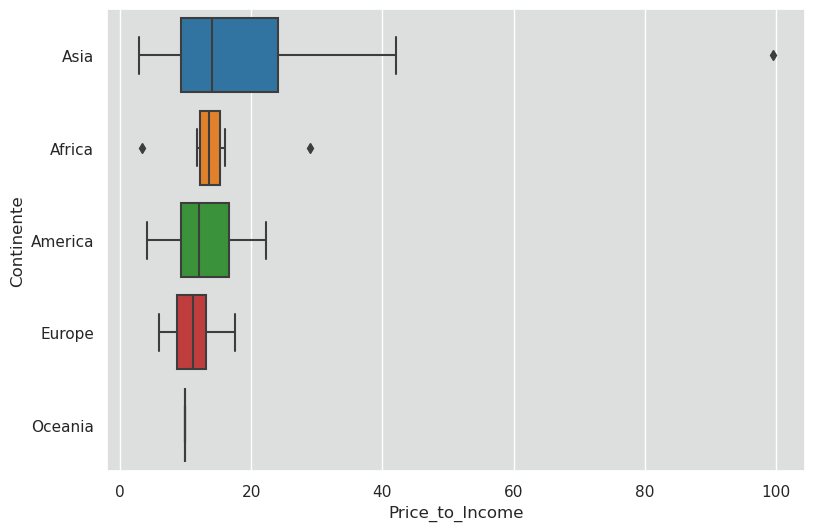

In [137]:
sns.boxplot(
    data = df_prop,
    x = 'Price_to_Income',
    y = 'Continente'
)

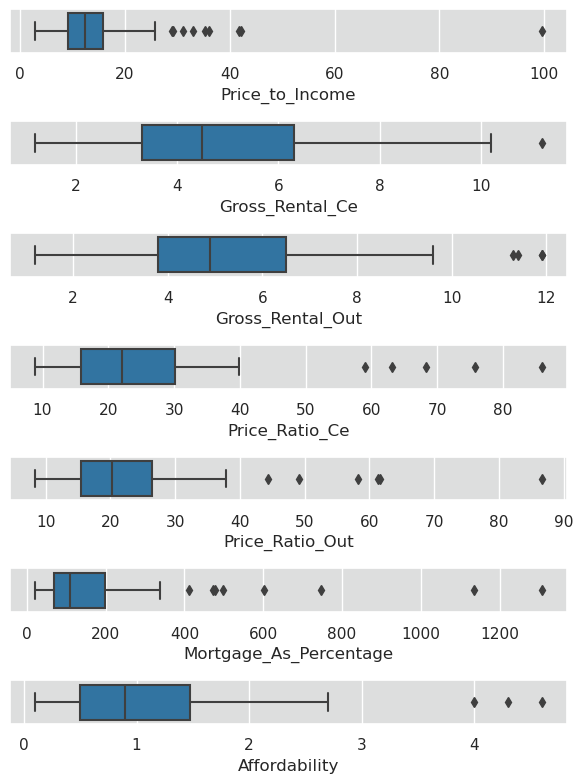

In [138]:
cols = df_prop.select_dtypes(np.number).columns

fig, ax = plt.subplots(7,figsize = (6,8))


for i, i_col in enumerate(cols):
    sns.boxplot(
        ax = ax[i],
        data = df_prop,
        x = i_col
    )
plt.tight_layout()


In [139]:
def Remove_Outlier(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

In [140]:
outliers = Remove_Outlier(df_prop)

prop = df_prop[outliers]
prop

/tmp/ipykernel_11692/1591930294.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.25)
/tmp/ipykernel_11692/1591930294.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.75)
/tmp/ipykernel_11692/1591930294.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))


,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affordability,Continente
0,Syria,NaN,2.8,4.2,35.9,24.1,NaN,0.1,Asia
1,Hong Kong (China),NaN,1.7,1.7,NaN,NaN,275.9,0.4,Asia
2,Cameroon,NaN,7.6,9.3,13.1,10.7,NaN,0.1,NaN
3,Nepal,NaN,1.5,2.0,NaN,NaN,NaN,0.2,Asia
4,Sri Lanka,NaN,3.8,2.3,26.0,NaN,NaN,0.2,Asia
...,...,...,...,...,...,...,...,...,...
101,United States,4.2,7.9,9.1,12.7,11.0,38.3,2.6,America
102,United Arab Emirates,3.3,9.7,9.2,10.3,10.8,23.1,NaN,Asia
103,South Africa,3.3,10.2,NaN,9.8,8.9,36.8,2.7,Africa
104,Oman,3.2,6.9,7.6,14.5,13.1,24.8,NaN,Asia


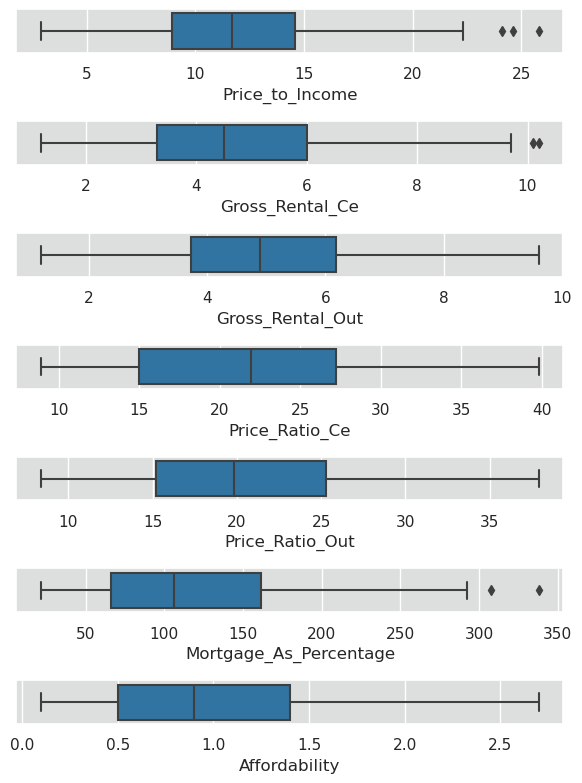

In [141]:
fig, ax = plt.subplots(7,figsize = (6,8))


for i, i_col in enumerate(cols):
    sns.boxplot(
        ax = ax[i],
        data = prop,
        x = i_col
    )
plt.tight_layout()

# Null Values

In [142]:
(
    prop
    .isnull()
    .sum()
)

Country                   0
Price_to_Income           9
Gross_Rental_Ce           1
Gross_Rental_Out          4
Price_Ratio_Ce            5
Price_Ratio_Out           6
Mortgage_As_Percentage    8
Affordability             3
Continente                2
dtype: int64

In [143]:
(
    prop
    .isnull()
    .sum()
    .sum()
)

38

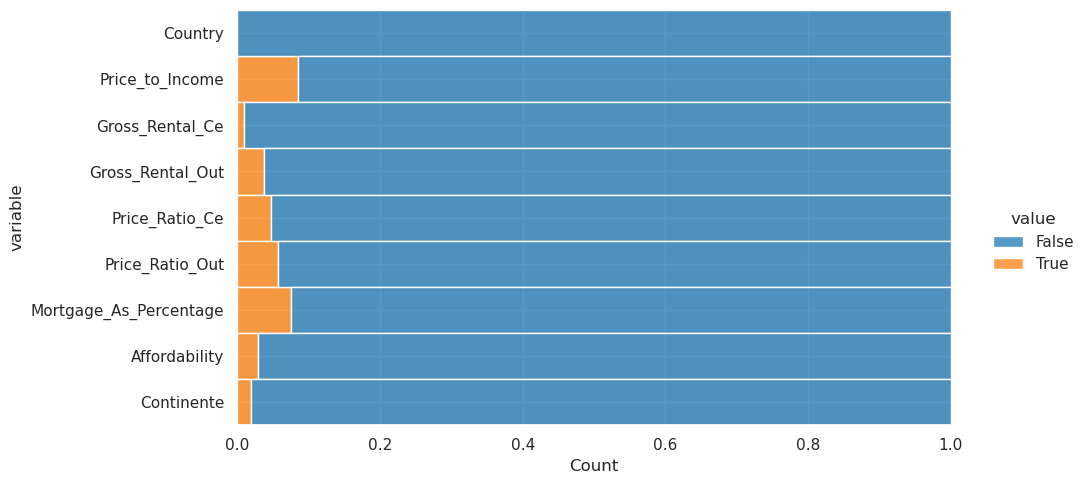

In [144]:
(
    prop
    .isnull()
    .melt()
    .pipe(
        lambda df:(
            sns.displot(
                data = df,
                y = 'variable',
                hue = 'value',
                multiple = 'fill',
                aspect = 2
            )
        )
    )
)

<Axes: >

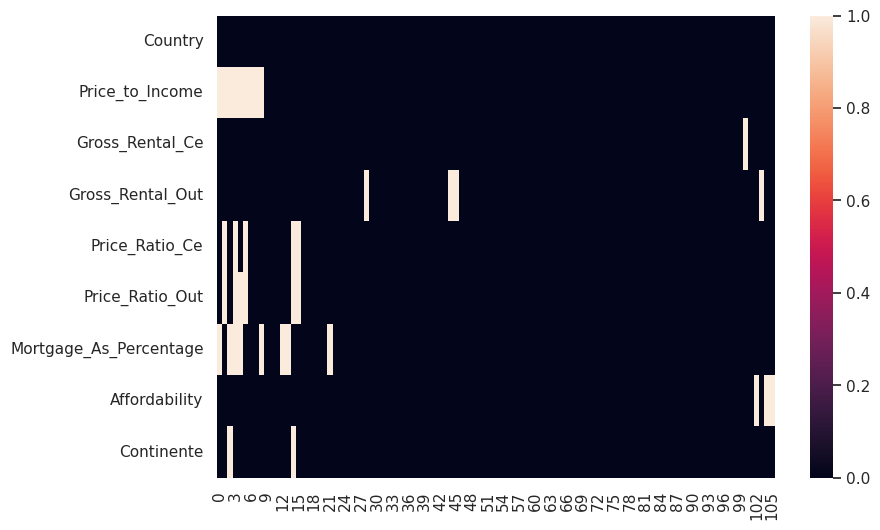

In [145]:
(
    prop
    .isnull()
    .transpose()
    .pipe(
        lambda df:(
            sns.heatmap(
                data = df
            )
        )
    )
)

<Axes: >

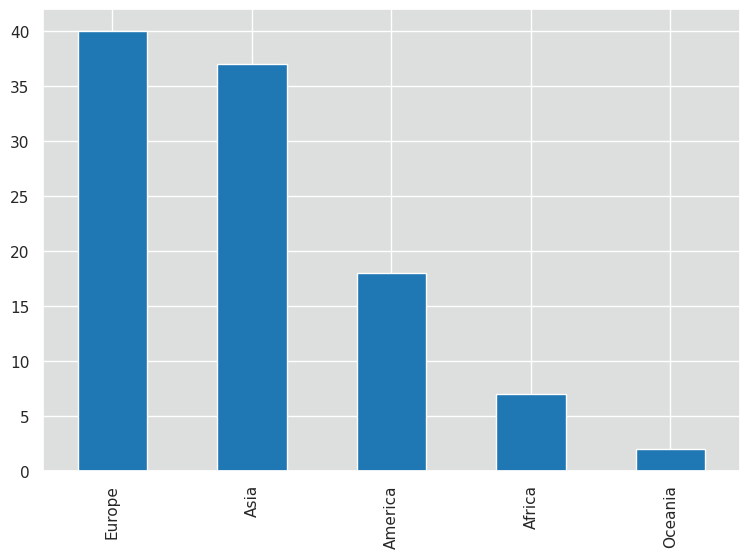

In [146]:
(
    prop['Continente']
    .value_counts()
    .plot(
        kind = 'bar'
    )
)

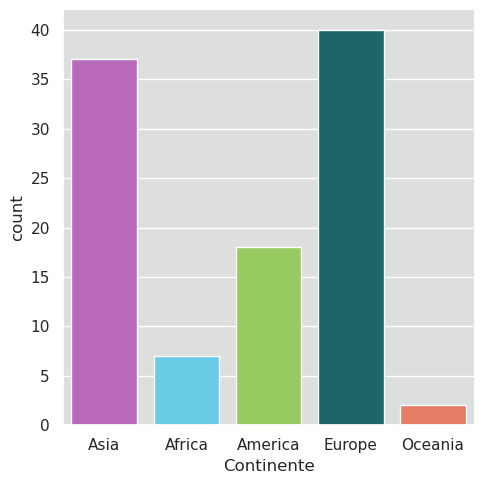

In [147]:
sns.catplot(
    data = prop,
    x = 'Continente',
    kind = 'count',
    palette= continent_color
)

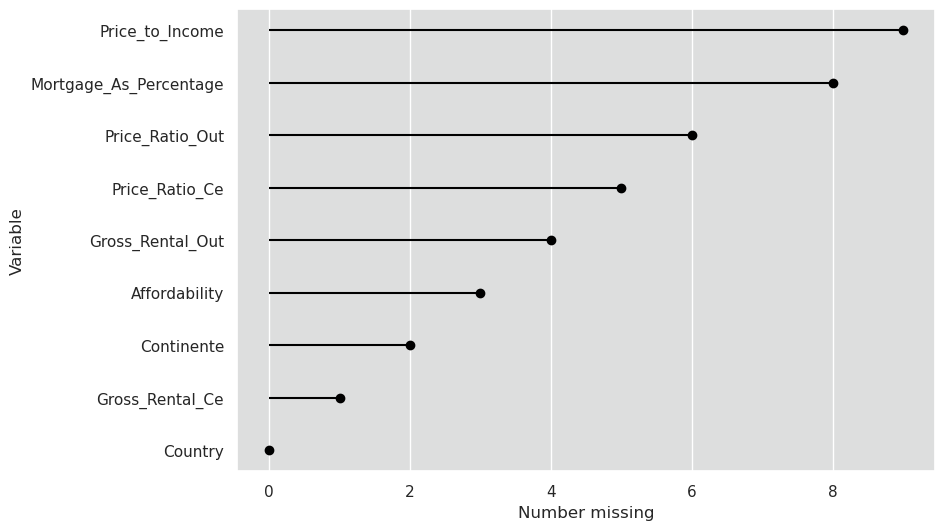

In [148]:
prop.missing.missing_variable_plot()

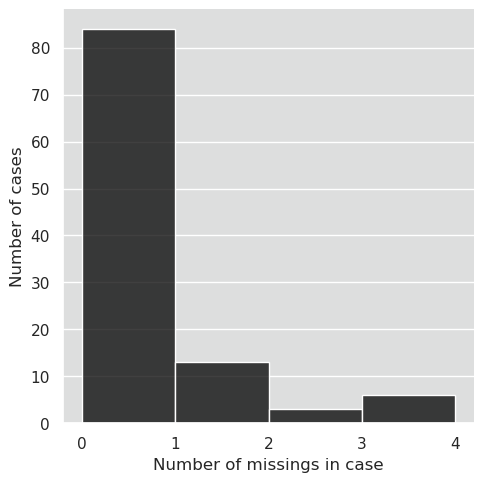

In [149]:
prop.missing.missing_case_plot()

<Axes: >

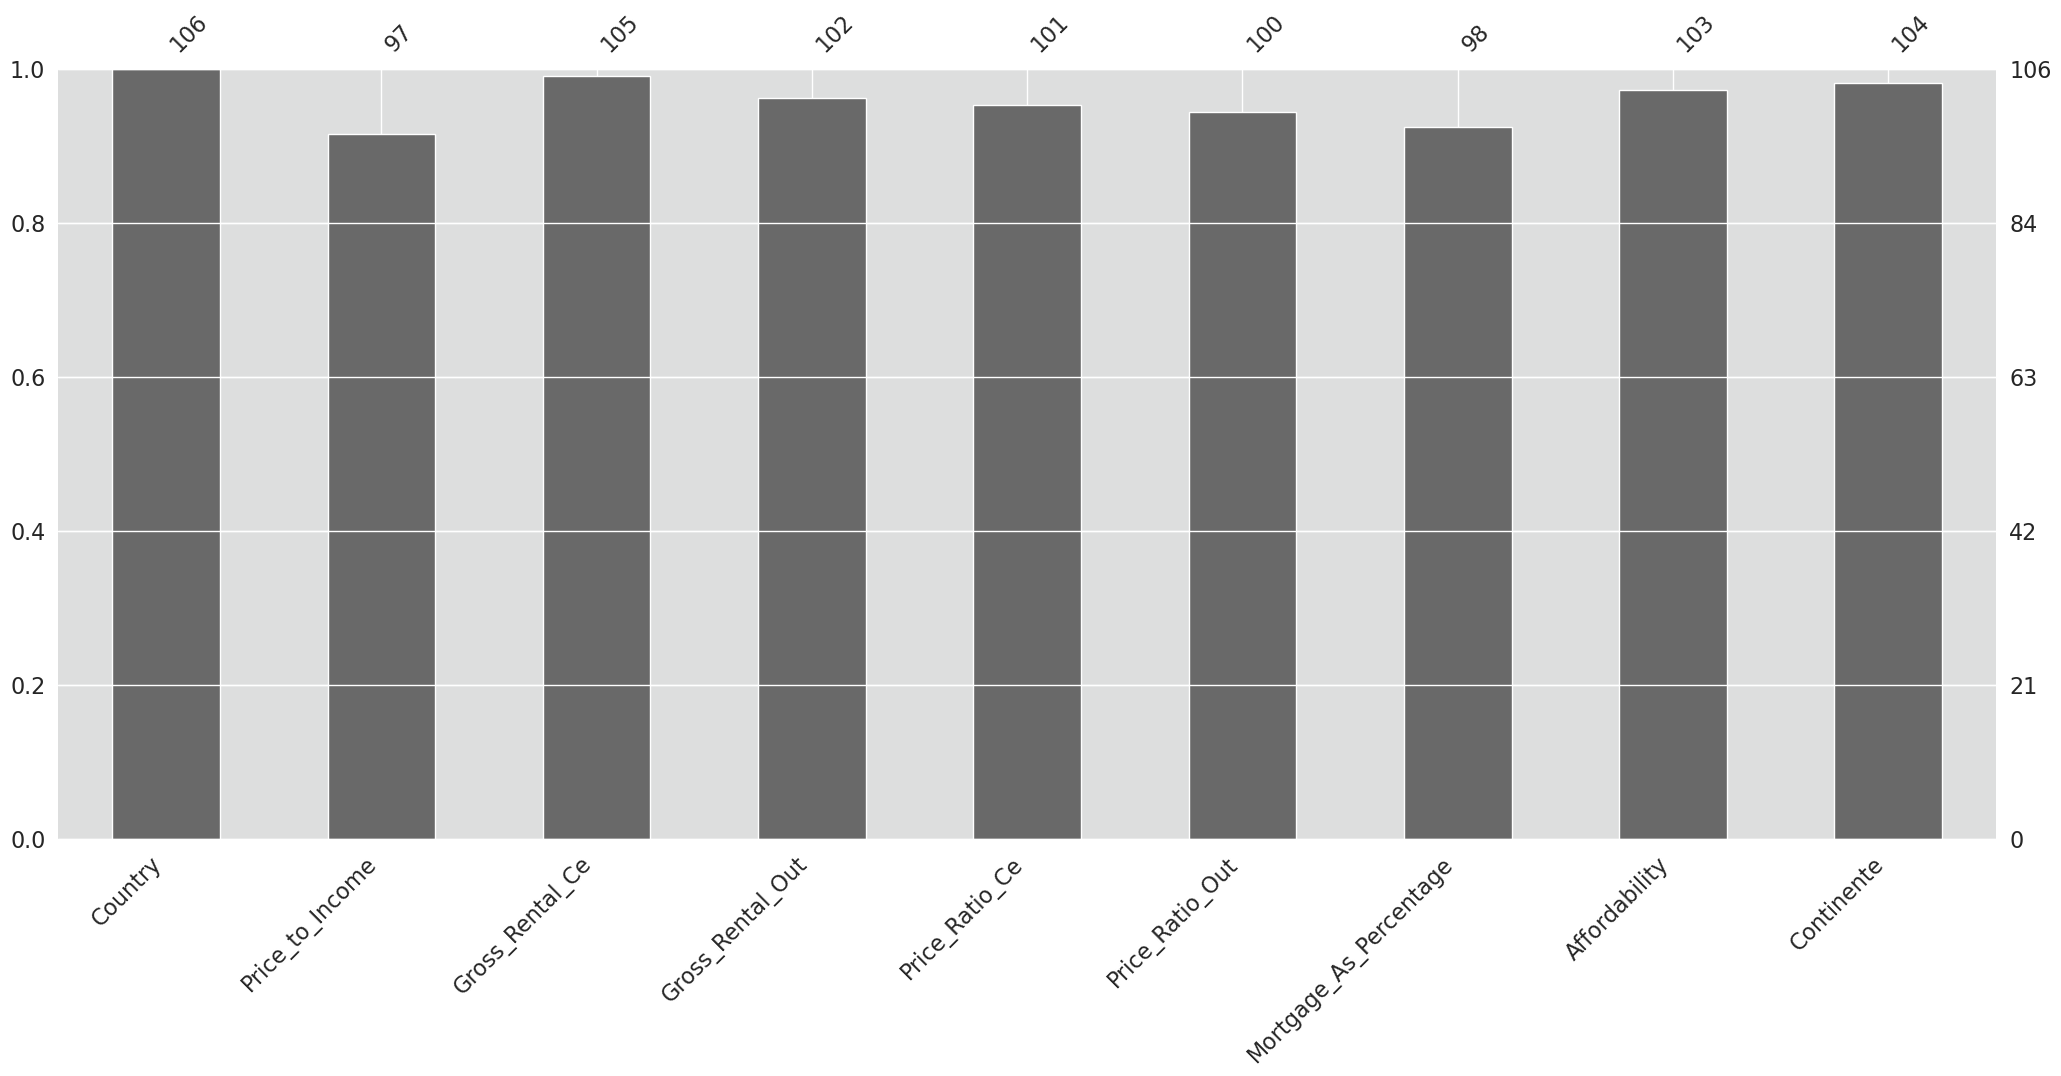

In [150]:
missingno.bar(df = prop)

<Axes: >

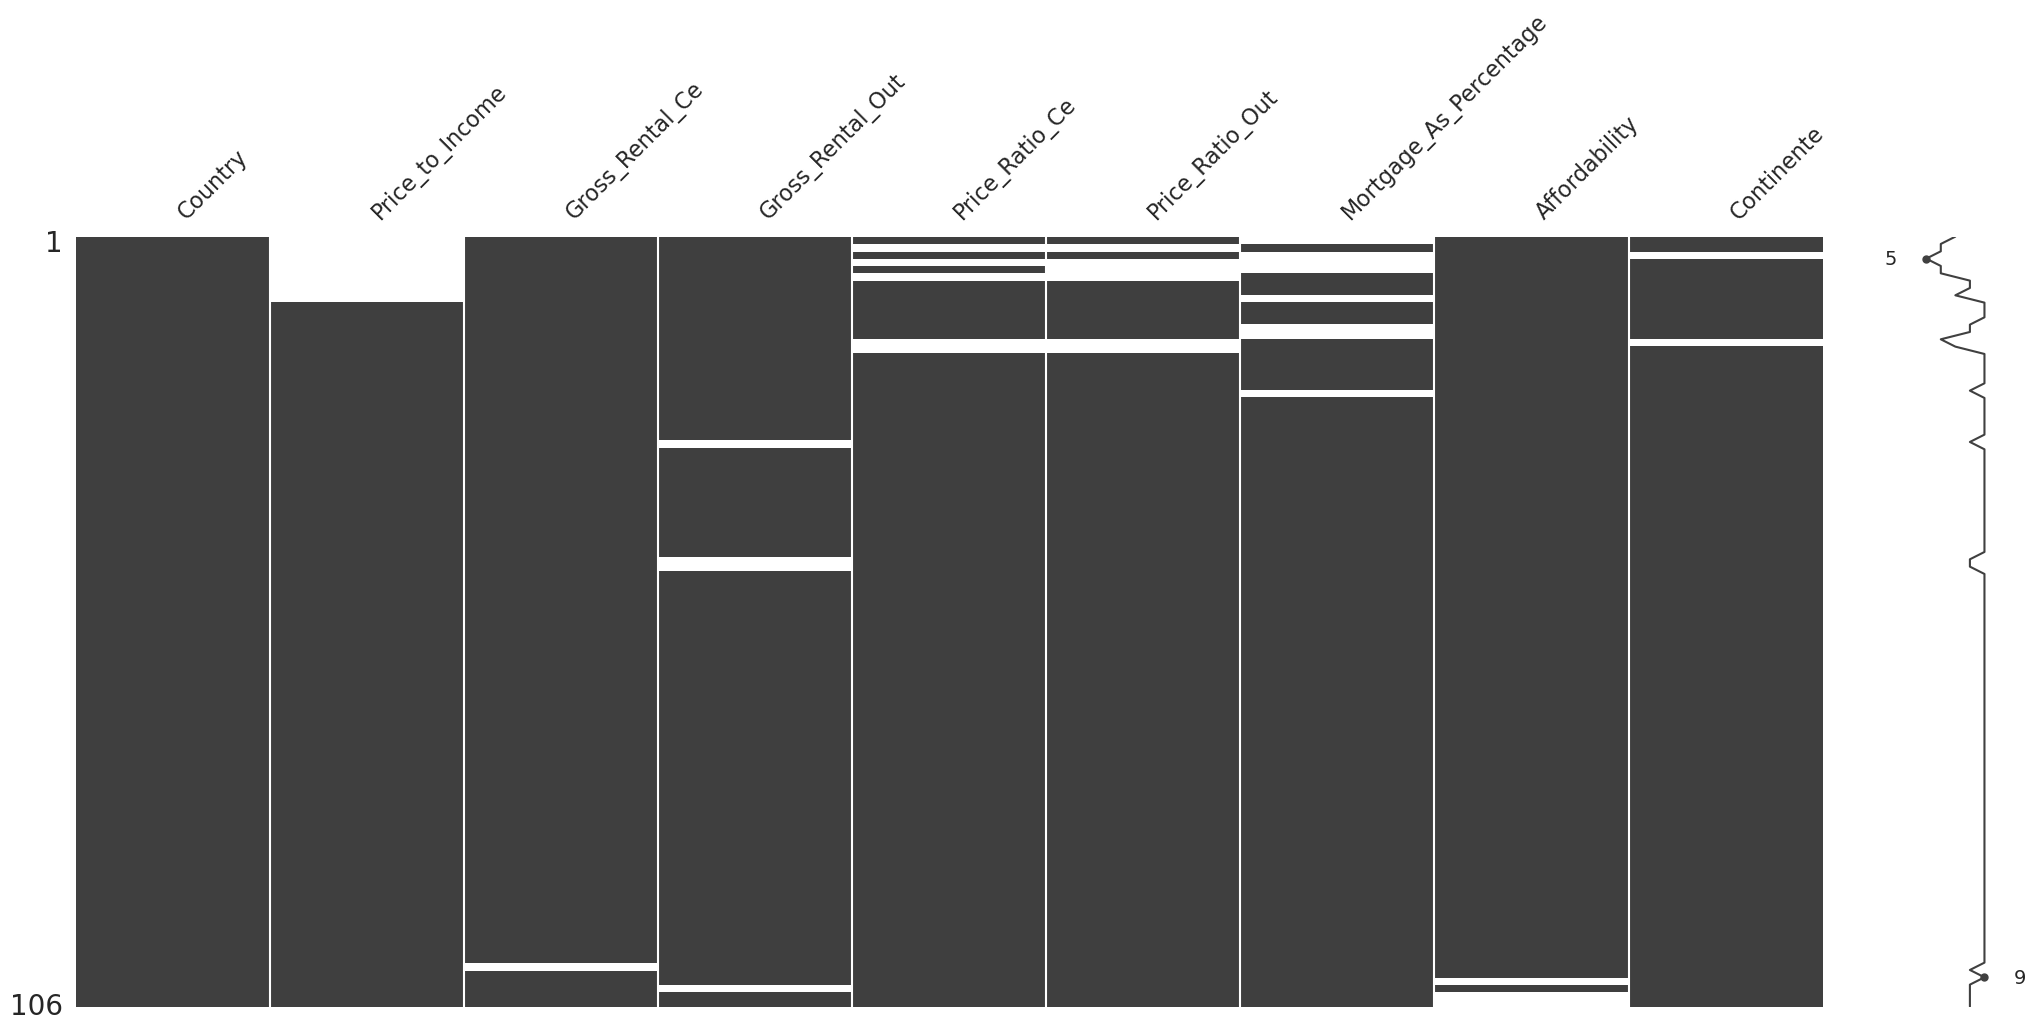

In [151]:
missingno.matrix(df = prop)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

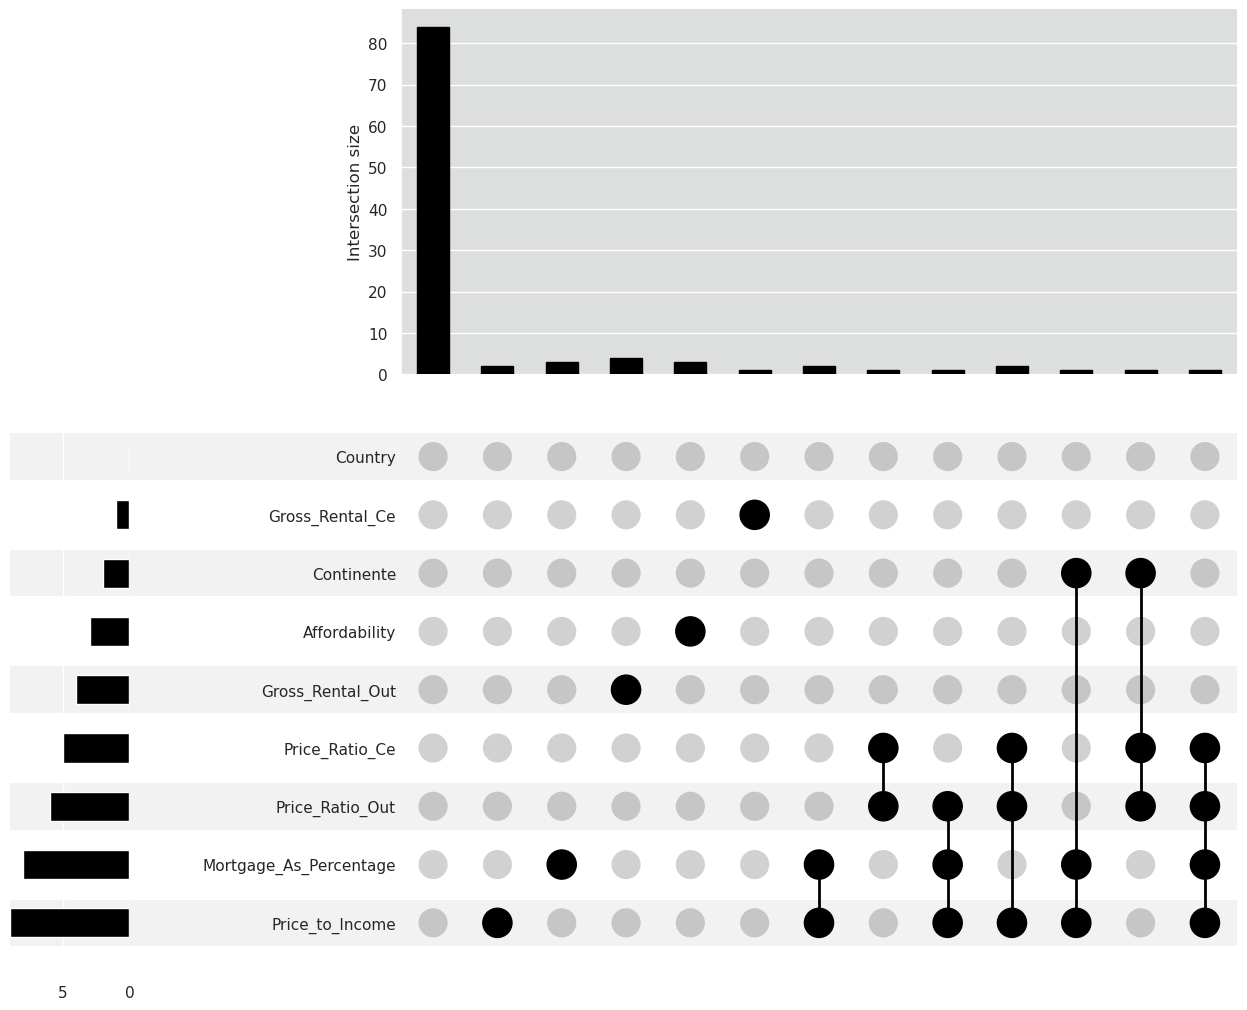

In [152]:
(
    prop
    .missing
    .missing_upsetplot(
        variables=None,
        element_size = 60 
    )
)

# Heatmap

/tmp/ipykernel_11692/1780434883.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mid = np.triu(prop.corr())
/tmp/ipykernel_11692/1780434883.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = prop.corr(),
/home/edwlearn/anaconda3/envs/best/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

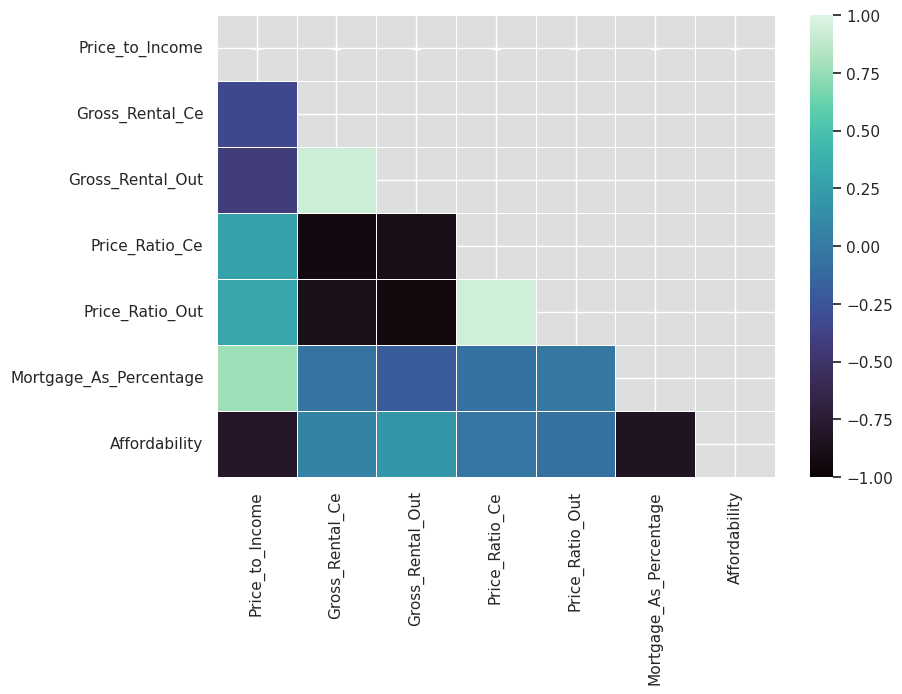

In [153]:
mid = np.triu(prop.corr())

sns.heatmap(
    data = prop.corr(),
    cmap = 'mako',
    center = 0,
    vmin = -1,
    vmax = 1,
    annot = True,
    linewidths= 0.5,
    mask = mid
)

# Correlations

- [ ] ¿Existe alguna relación entre el ratio precio-ingreso y el índice de asequibilidad?


<Axes: xlabel='Mortgage_As_Percentage', ylabel='Price_to_Income'>

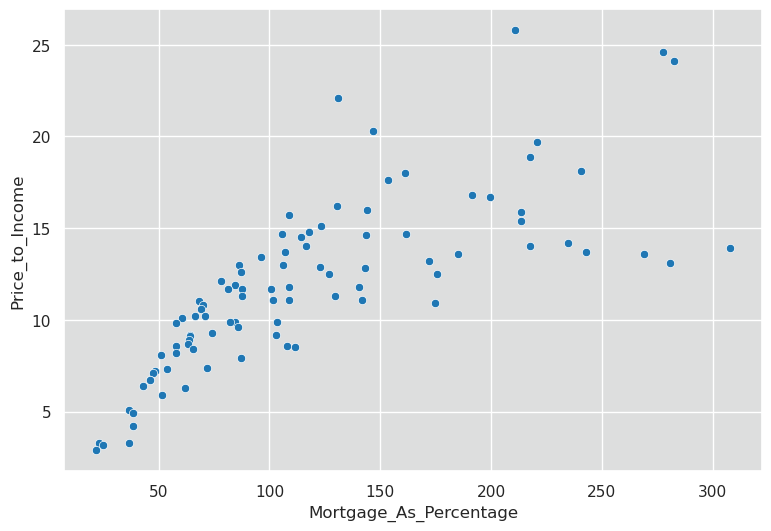

In [154]:
sns.scatterplot(
    data= prop, 
    x= 'Mortgage_As_Percentage',
    y = 'Price_to_Income',
)

- [ ] ¿Está relacionado el rendimiento bruto de alquiler en el centro de la ciudad con el ratio precio-alquiler en el centro de la ciudad?


<Axes: xlabel='Gross_Rental_Ce', ylabel='Price_Ratio_Ce'>

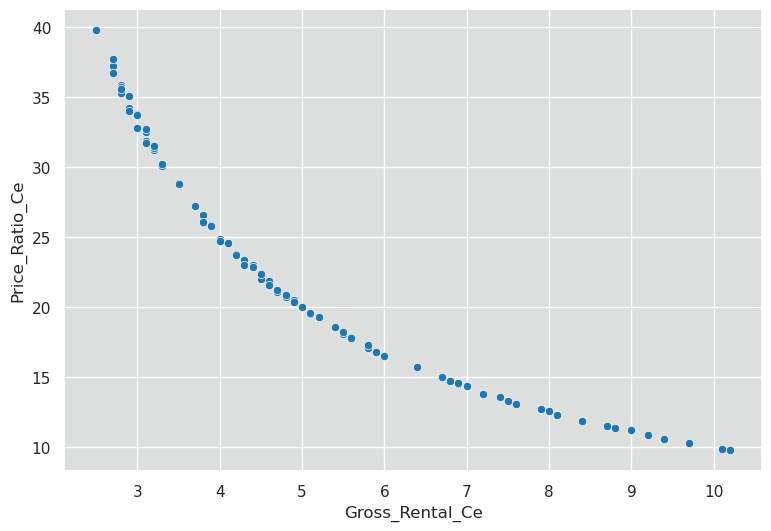

In [155]:
sns.scatterplot(
    data= prop, 
    x= 'Gross_Rental_Ce',
    y = 'Price_Ratio_Ce',
)

- [ ] ¿Existe alguna correlación entre el ratio precio-alquiler fuera de la ciudad y el rendimiento bruto de alquiler fuera de la ciudad?


<Axes: xlabel='Price_Ratio_Out', ylabel='Gross_Rental_Out'>

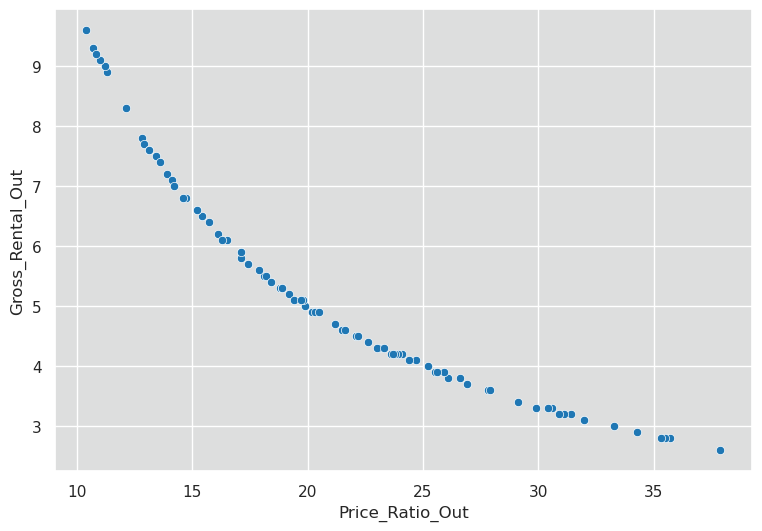

In [156]:
sns.scatterplot(
    data= prop, 
    x= 'Price_Ratio_Out',
    y = 'Gross_Rental_Out',
)

- [ ] ¿Está relacionado el ratio precio-ingreso con el porcentaje de ingresos dedicados a la hipoteca?


<Axes: xlabel='Price_to_Income', ylabel='Mortgage_As_Percentage'>

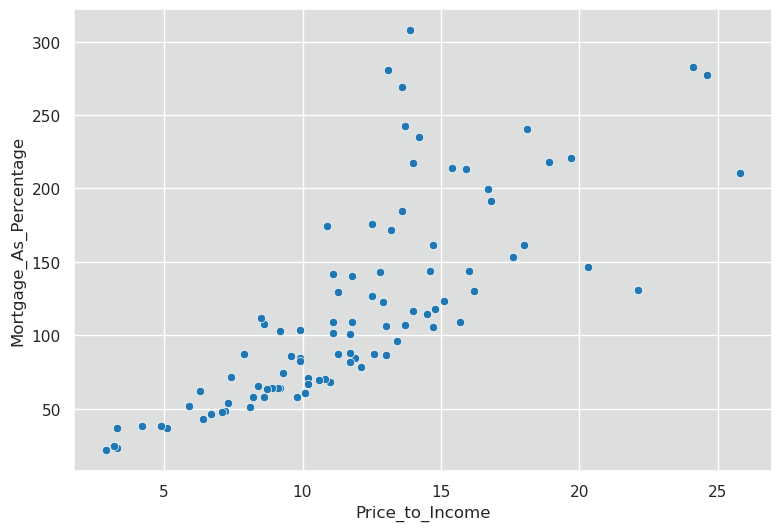

In [157]:
sns.scatterplot(
    data= prop, 
    x= 'Price_to_Income',
    y = 'Mortgage_As_Percentage',
)

- [ ] ¿Hay alguna relación entre el rendimiento bruto de alquiler fuera del centro de la ciudad y el porcentaje de ingresos dedicados a la hipoteca?

<Axes: xlabel='Price_Ratio_Ce', ylabel='Price_Ratio_Out'>

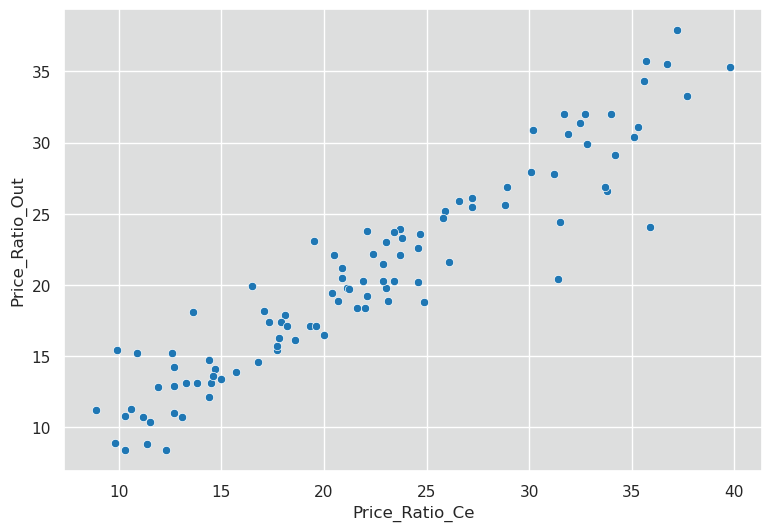

In [158]:
sns.scatterplot(
    data= prop, 
    x= 'Price_Ratio_Ce',
    y = 'Price_Ratio_Out',
)

- [ ] ¿Hay alguna relación entre la proporción de ingresos dedicados a la hipoteca y el índice de asequibilidad en cada país?


In [159]:
sns.scatterplot(
    data= prop, 
    x= 'Affortability',
    y = 'Mortgage_As_Percentage',
)

ValueError: Could not interpret value `Affortability` for parameter `x`

## 1 Variable

In [ ]:
df_prop['Gross_Different'] = round(df_prop['Gross_Rental_Ce'] - df_prop['Gross_Rental_Out'],1)
df_prop['Price_Ratio_Different'] = round(df_prop['Price_Ratio_Ce'] - df_prop['Price_Ratio_Out'],1)

In [ ]:
df_america = df_prop[df_prop['Continente'] == 'America']
df_europe = df_prop[df_prop['Continente'] == 'Europe']
df_asia = df_prop[df_prop['Continente'] == 'Asia']
df_oceania = df_prop[df_prop['Continente'] == 'Oceania']
df_africa = df_prop[df_prop['Continente'] == 'Africa']

- [ ] 
¿Hay alguna diferencia en el ratio precio-alquiler en el centro de la ciudad en comparación con el ratio precio-alquiler fuera de la ciudad en cada país?

/tmp/ipykernel_82/1711561656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  difference['Difference'] =  round(difference['Gross_Rental_Out'] - difference['Gross_Rental_Ce'], 1)


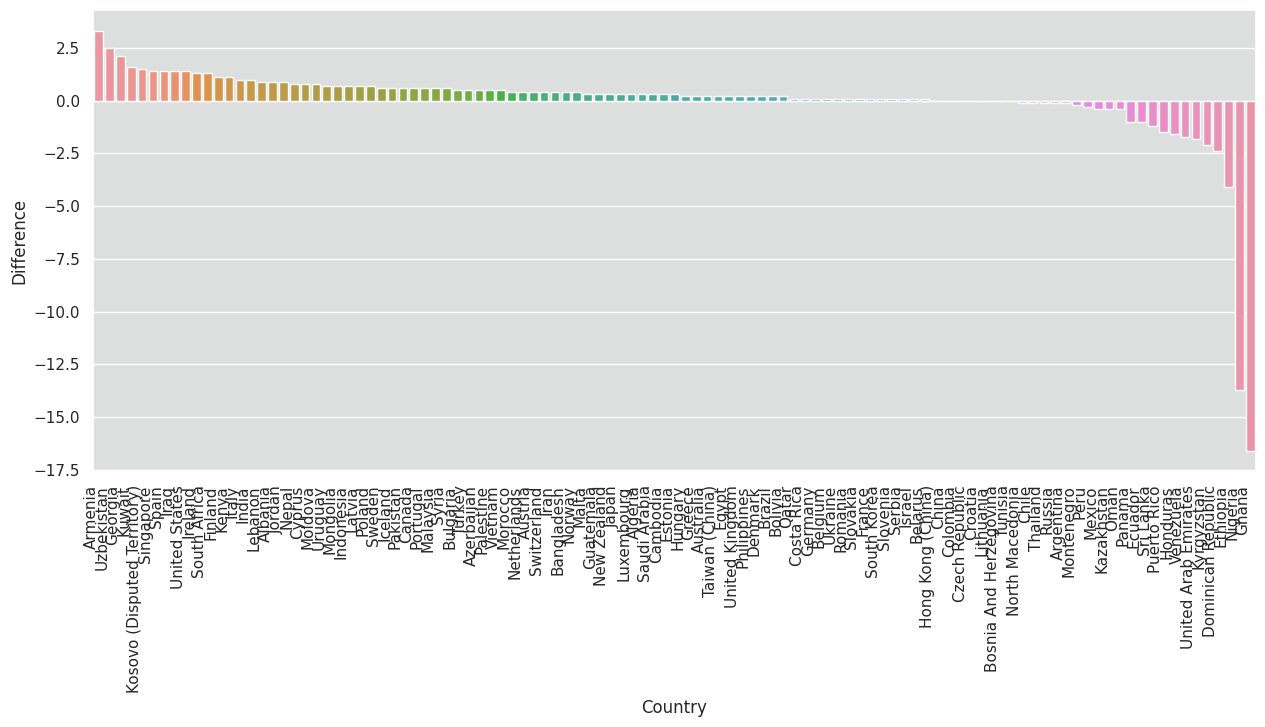

In [ ]:
difference = df_prop[['Country', 'Gross_Rental_Ce', 'Gross_Rental_Out', 'Continente']]
difference['Difference'] =  round(difference['Gross_Rental_Out'] - difference['Gross_Rental_Ce'], 1)
difference= difference.sort_values('Difference',ascending=False)

fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(
    data = difference,
    x = 'Country',
    y = 'Difference',
    ax = ax
    
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

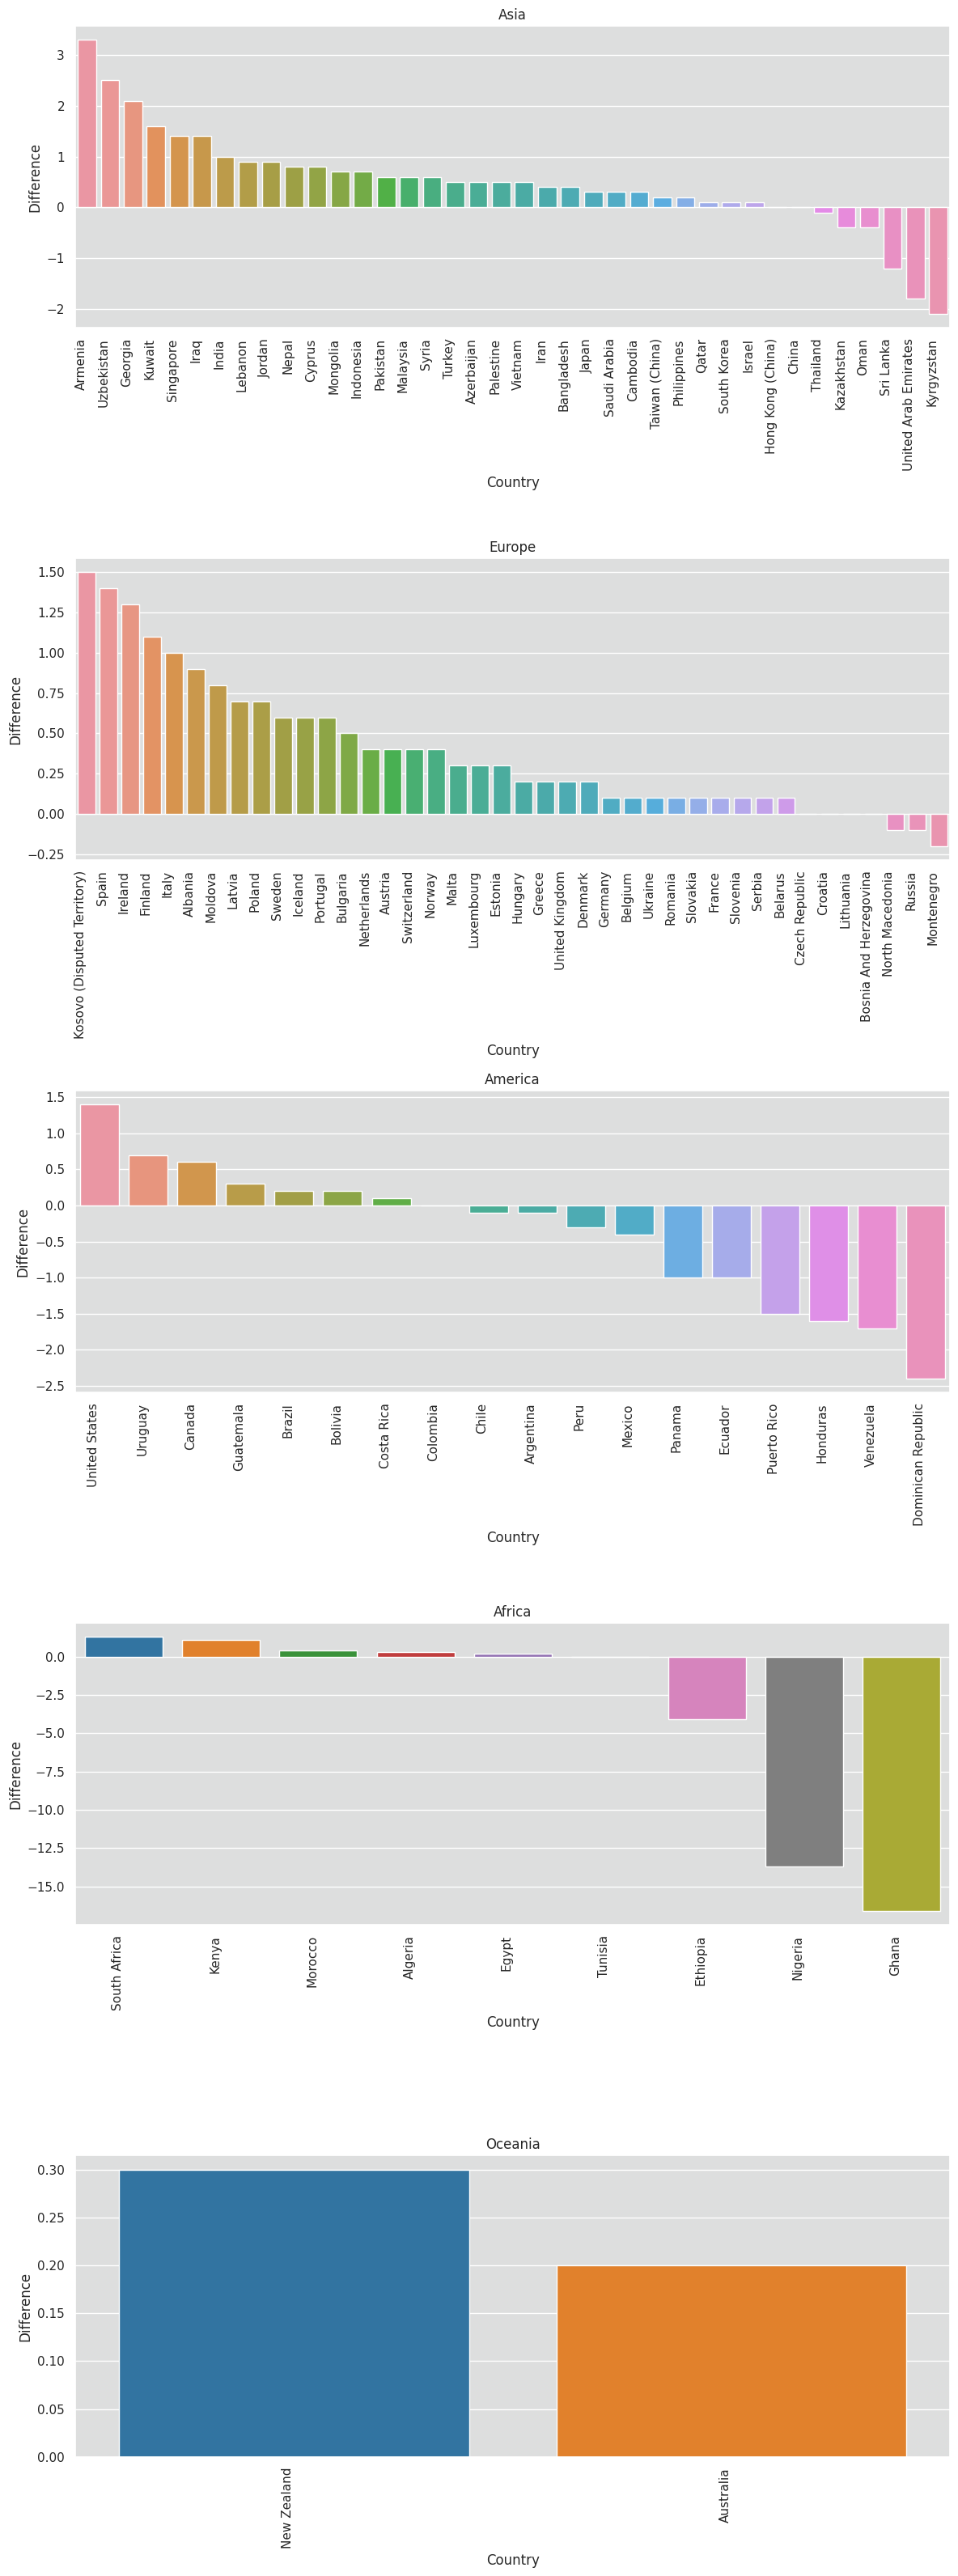

In [ ]:
continents = list(difference['Continente'].unique())
continents

fig, ax = plt.subplots(5, figsize = (12,32))

for i, i_col in enumerate(continents):
    sns.barplot(
        ax = ax[i],
        data = difference[difference['Continente'] == f'{i_col}'],
        x = 'Country',
        y = 'Difference'
    )
    #print(f'i:{i}, i_col:{i_col}')
    #print(difference[difference['Continente'] == f'{i_col}'])

for j, j_col in enumerate(continents):
    ax[j].set_title(f'{j_col}')    

for i, i_col in enumerate(continents):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, horizontalalignment='right')

plt.tight_layout()
plt.show()

- [ ] ¿Cuál es el continente con el mayor ratio precio-ingreso promedio y el mayor rendimiento bruto de alquiler en el centro de la ciudad?


<AxesSubplot: xlabel='Continente', ylabel='Price_to_Income'>

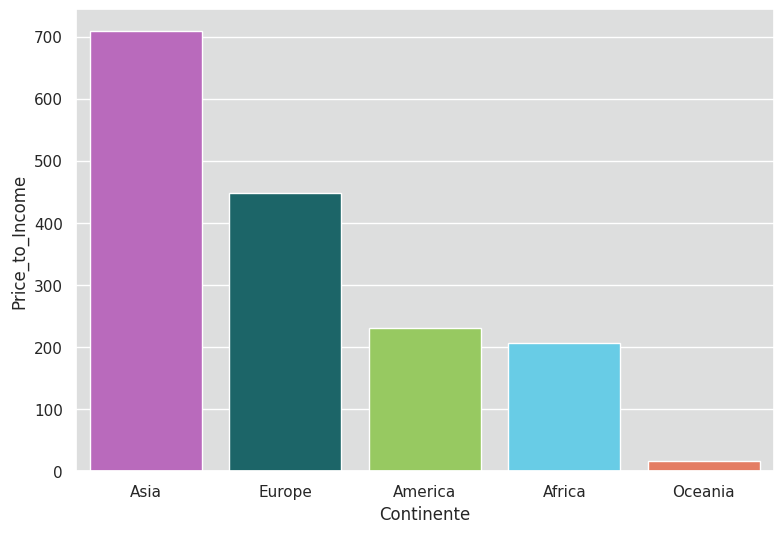

In [ ]:
price_inc =df_prop.groupby('Continente')[['Price_to_Income','Gross_Rental_Ce']].sum()

price_inc.sort_values('Price_to_Income', ascending= False, inplace=True)

price_inc.reset_index(inplace=True)

sns.barplot(
    data = price_inc,
    x = 'Continente',
    y = 'Price_to_Income',
    palette= continent_color
)


- [ ] ¿Qué continente tiene el mayor ratio precio-ingreso y el mayor porcentaje de ingresos dedicados a la hipoteca?


- [ ] ¿Qué continente tiene el mayor rendimiento bruto de alquiler fuera del centro de la ciudad y el mayor ratio precio-alquiler fuera de la ciudad?


- [ ] ¿Cuál es el continente con el índice de asequibilidad más bajo y el mayor ratio precio-alquiler fuera de la ciudad?


<AxesSubplot: xlabel='Continente', ylabel='Mortgage_As_Percentage'>

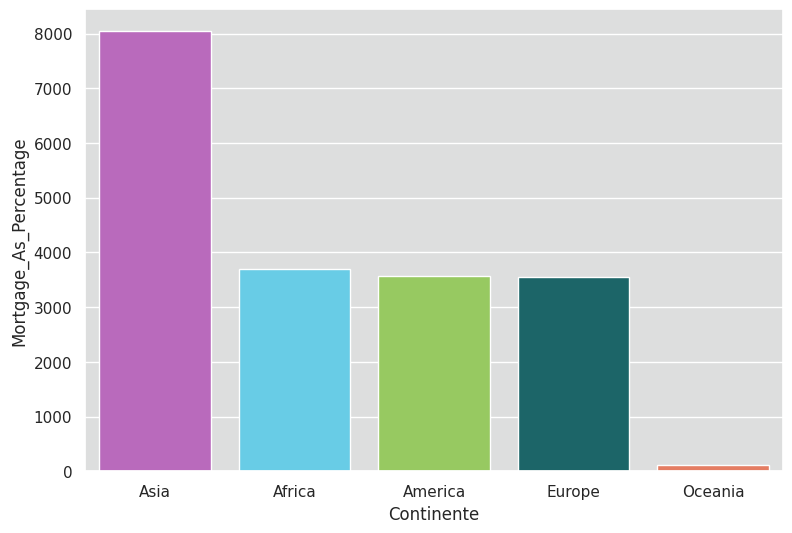

In [ ]:
mortgage = df_prop.groupby(['Continente'])['Mortgage_As_Percentage'].sum()
mortgage = pd.DataFrame(mortgage)
mortgage.reset_index(inplace=True) 

sns.barplot(
    data = mortgage,
    x = 'Continente',
    y = 'Mortgage_As_Percentage',
    palette= continent_color,
    order = mortgage.sort_values('Mortgage_As_Percentage', ascending = False).Continente
)

- [ ] ¿Cuál es el continente con el mayor rendimiento bruto de alquiler en el centro de la ciudad y el mayor rendimiento bruto de alquiler fuera del centro de la ciudad?


In [ ]:
df_prop.columns

Index(['Country', 'Price_to_Income', 'Gross_Rental_Ce', 'Gross_Rental_Out',
       'Price_Ratio_Ce', 'Price_Ratio_Out', 'Mortgage_As_Percentage',
       'Affortability', 'Continente', 'Gross_Different',
       'Price_Ratio_Different'],
      dtype='object')

In [ ]:
gross = df_prop.groupby('Continente')[['Gross_Rental_Ce','Gross_Rental_Out']].sum()

gross.reset_index(inplace = True)
gross.sort_values('Gross_Rental_Ce', ascending=False)

,Continente,Gross_Rental_Ce,Gross_Rental_Out
2,Asia,194.3,212.6
3,Europe,162.6,178.1
1,America,113.9,107.3
0,Africa,90.4,59.3
4,Oceania,8.6,9.1


- [ ] 
¿Qué continente tiene la mayor diferencia en el rendimiento bruto de alquiler entre el centro de la ciudad y fuera de la ciudad?


- [ ] ¿Qué continente tiene la mayor proporción de ingresos dedicados a la hipoteca? ¿Cómo se compara con otros continentes?


- [ ] ¿Cómo se compara el rendimiento bruto de alquiler en países con diferentes ratios precio-ingreso?

In [ ]:
df_america.sort_values('Price_to_Income', ascending= True)

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affortability,Continente,Gross_Different,Price_Ratio_Different
102,United States,4.5,8.2,9.6,12.2,10.4,36.4,2.8,America,-1.4,1.8
101,Puerto Rico,4.5,10.9,9.4,9.2,10.6,34.8,2.9,America,1.5,-1.4
83,Mexico,8.4,7.8,7.4,12.7,13.5,104.6,1.0,America,0.4,-0.8
82,Honduras,8.9,7.4,5.8,13.4,17.3,117.7,0.8,America,1.6,-3.9
78,Canada,9.4,3.7,4.3,27.0,23.0,77.6,1.3,America,-0.6,4.0
77,Costa Rica,9.5,6.5,6.6,15.3,15.3,106.6,0.9,America,-0.1,0.0
72,Panama,10.2,9.1,8.1,11.0,12.3,86.9,1.2,America,1.0,-1.3
69,Bolivia,10.5,5.7,5.9,17.5,16.9,99.7,1.0,America,-0.2,0.6
66,Ecuador,11.1,6.4,5.4,15.7,18.7,126.5,0.8,America,1.0,-3.0
58,Guatemala,11.9,7.9,8.2,12.6,12.3,121.4,0.8,America,-0.3,0.3


In [ ]:
df_europe.sort_values('Price_to_Income', ascending= True)

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affortability,Continente,Gross_Different,Price_Ratio_Different
98,Belgium,6.5,4.7,4.8,21.1,20.7,39.0,2.6,Europe,-0.1,0.4
97,Denmark,6.6,4.4,4.6,22.7,21.9,38.8,2.6,Europe,-0.2,0.8
95,Iceland,7.0,5.4,6.0,18.6,16.5,57.1,1.8,Europe,-0.6,2.1
94,Netherlands,7.2,4.7,5.1,21.3,19.5,45.1,2.2,Europe,-0.4,1.8
93,Ireland,7.3,6.8,8.1,14.7,12.3,50.2,2.0,Europe,-1.3,2.4
90,Spain,7.8,4.8,6.2,20.7,16.2,48.5,2.1,Europe,-1.4,4.5
89,Finland,7.8,3.3,4.4,30.0,22.7,44.9,2.2,Europe,-1.1,7.3
87,Latvia,8.1,4.3,5.0,23.1,20.1,51.3,1.9,Europe,-0.7,3.0
85,Norway,8.1,3.6,4.0,27.9,24.9,53.3,1.9,Europe,-0.4,3.0
84,United Kingdom,8.3,4.4,4.6,22.5,21.8,56.4,1.8,Europe,-0.2,0.7


In [ ]:
df_asia.sort_values('Price_to_Income', ascending= True)

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affortability,Continente,Gross_Different,Price_Ratio_Different
106,United Arab Emirates,3.0,12.2,10.4,8.2,9.6,20.8,4.8,Asia,1.8,-1.4
105,Saudi Arabia,3.0,6.9,7.2,14.5,13.9,22.0,4.5,Asia,-0.3,0.6
103,Oman,3.6,7.2,6.8,13.9,14.6,28.0,3.6,Asia,0.4,-0.7
100,Qatar,5.3,7.7,7.8,13.0,12.9,38.4,2.6,Asia,-0.1,0.1
99,Palestine,5.6,7.6,8.1,13.2,12.3,50.6,2.0,Asia,-0.5,0.9
96,Cyprus,6.8,9.4,10.2,10.7,9.8,44.2,2.3,Asia,-0.8,0.9
92,Jordan,7.4,5.8,6.7,17.2,14.8,72.5,1.4,Asia,-0.9,2.4
88,Malaysia,8.1,4.4,5.0,22.9,20.1,58.1,1.7,Asia,-0.6,2.8
86,Iraq,8.1,6.5,7.9,15.4,12.7,89.7,1.1,Asia,-1.4,2.7
79,India,9.2,3.2,4.2,31.6,23.9,94.9,1.1,Asia,-1.0,7.7


In [ ]:
df_africa.sort_values('Price_to_Income', ascending= True)

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affortability,Continente,Gross_Different,Price_Ratio_Different
104,South Africa,3.4,9.9,11.2,10.1,8.9,36.0,2.8,Africa,-1.3,1.2
59,Tunisia,11.9,4.9,4.9,20.5,20.3,144.8,0.7,Africa,0.0,0.2
57,Egypt,12.0,6.8,7.0,14.7,14.3,162.0,0.6,Africa,-0.2,0.4
36,Morocco,14.2,4.6,5.0,21.7,19.8,111.2,0.9,Africa,-0.4,1.9
25,Kenya,16.0,3.5,4.6,28.5,21.7,216.9,0.5,Africa,-1.1,6.8
26,Algeria,16.0,3.4,3.7,29.6,27.1,143.2,0.7,Africa,-0.3,2.5
9,Ethiopia,26.4,10.9,6.8,9.1,14.8,445.7,0.2,Africa,4.1,-5.7
8,Nigeria,28.2,29.4,15.7,3.4,6.4,507.8,0.2,Africa,13.7,-3.0
1,Ghana,78.6,17.0,0.4,5.9,255.1,1937.5,0.1,Africa,16.6,-249.2


## Mejores paises para Comprar en el centro de la ciudad Por continente

In [ ]:
df_america[['Country','Price_Ratio_Ce']].sort_values('Price_Ratio_Ce', ascending=False)

,Country,Price_Ratio_Ce
14,Argentina,41.1
78,Canada,27.0
19,Brazil,25.6
42,Uruguay,24.4
30,Chile,22.3
22,Colombia,21.0
16,Peru,20.6
69,Bolivia,17.5
66,Ecuador,15.7
77,Costa Rica,15.3


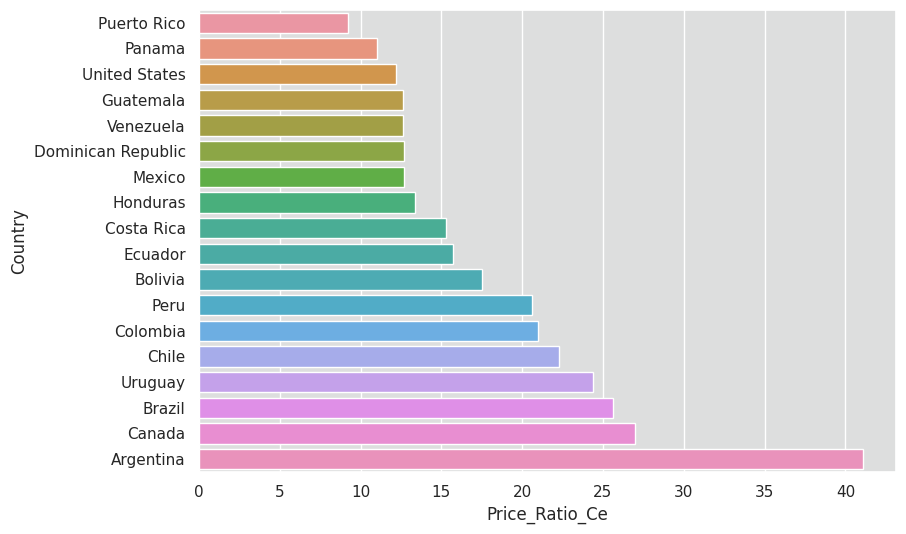

In [ ]:
fig, ax = plt.subplots()

sns.barplot(
    data = df_america,
    y = 'Country',
    x = 'Price_Ratio_Ce',
    order = df_america.sort_values('Price_Ratio_Ce', ascending = True).Country,
    ax = ax
)

#ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
plt.show()

## Europe

In [ ]:
df_europe[['Country','Price_Ratio_Ce']].sort_values('Price_Ratio_Ce', ascending=True)

,Country,Price_Ratio_Ce
93,Ireland,14.7
53,Ukraine,17.3
51,Portugal,18.4
95,Iceland,18.6
54,Moldova,18.7
56,Malta,18.8
48,Montenegro,18.8
90,Spain,20.7
41,Belarus,20.9
98,Belgium,21.1


<AxesSubplot: xlabel='Price_Ratio_Ce', ylabel='Country'>

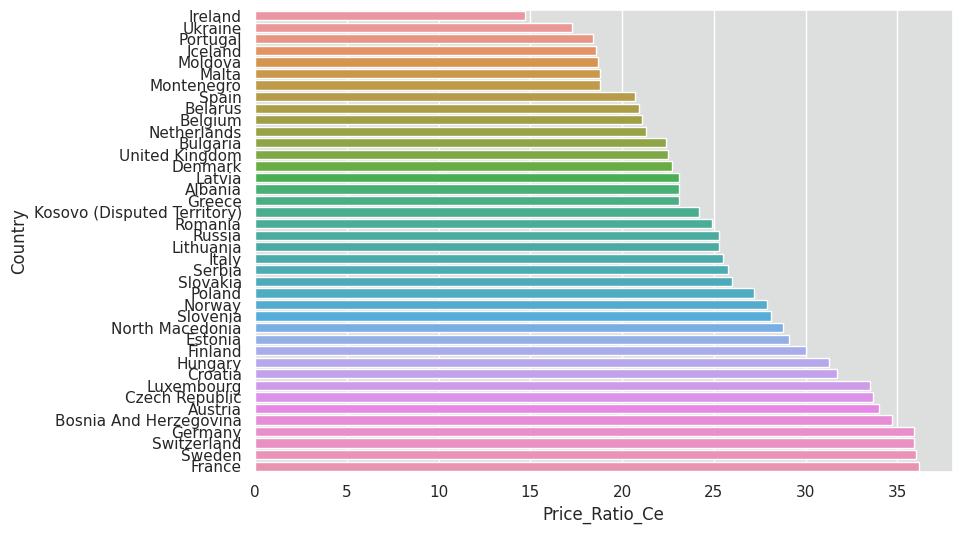

In [ ]:
sns.barplot(
    df_europe,
    x = 'Price_Ratio_Ce',
    y = 'Country',
    order = df_europe.sort_values('Price_Ratio_Ce', ascending=True).Country
)

In [ ]:
df_europe[['Country','Price_Ratio_Ce', 'Price_Ratio_Out', 'Price_Ratio_Different']]

,Country,Price_Ratio_Ce,Price_Ratio_Out,Price_Ratio_Different
24,Russia,25.3,26.6,-1.3
27,Serbia,25.8,25.1,0.7
29,Albania,23.1,19.1,4.0
32,Czech Republic,33.7,32.9,0.8
33,Hungary,31.3,29.4,1.9
37,Kosovo (Disputed Territory),24.2,18.0,6.2
41,Belarus,20.9,20.4,0.5
44,Poland,27.2,23.0,4.2
45,North Macedonia,28.8,29.5,-0.7
46,Slovakia,26.0,25.8,0.2


## Asia

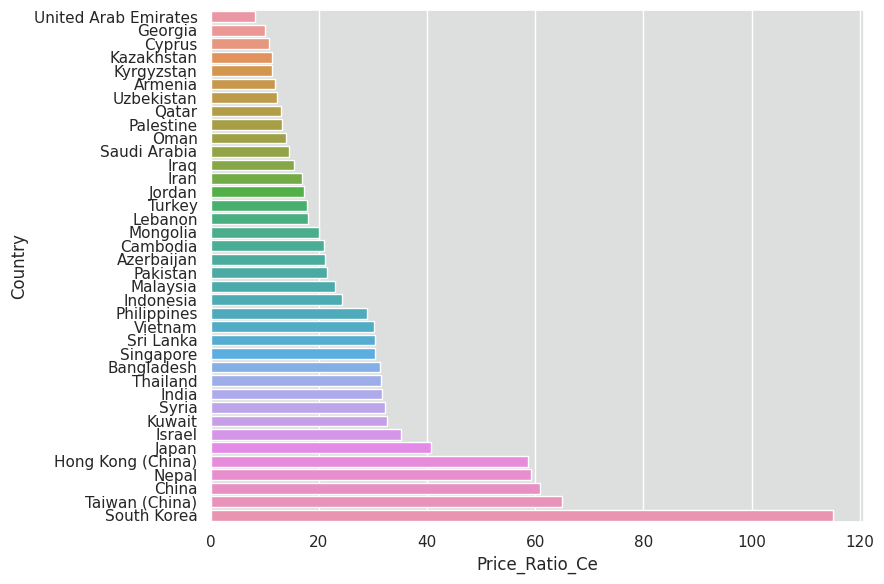

In [ ]:
sns.barplot(
    df_asia,
    x = 'Price_Ratio_Ce',
    y = 'Country',
    order = df_asia.sort_values('Price_Ratio_Ce', ascending=True).Country
)
plt.tight_layout()

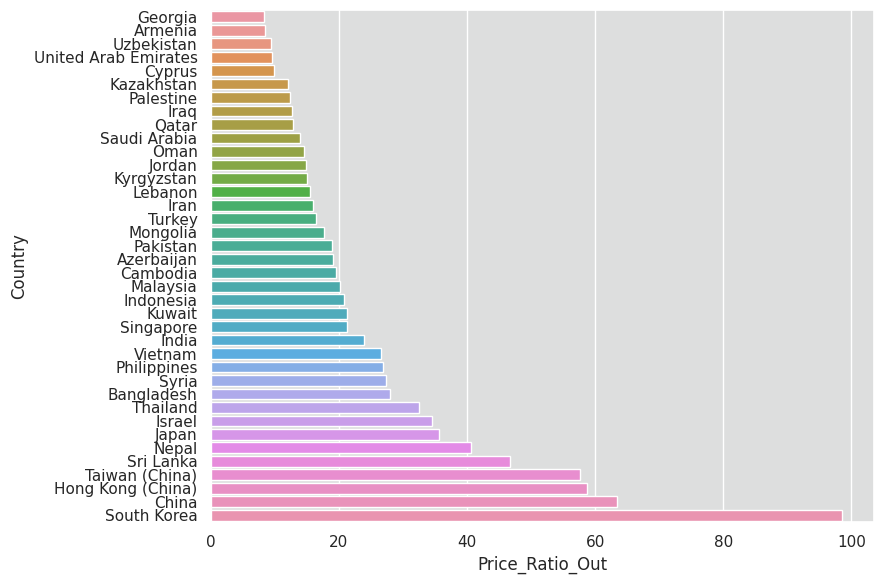

In [ ]:
sns.barplot(
    df_asia,
    x = 'Price_Ratio_Out',
    y = 'Country',
    order = df_asia.sort_values('Price_Ratio_Out', ascending=True).Country
)
plt.tight_layout()

## Africa

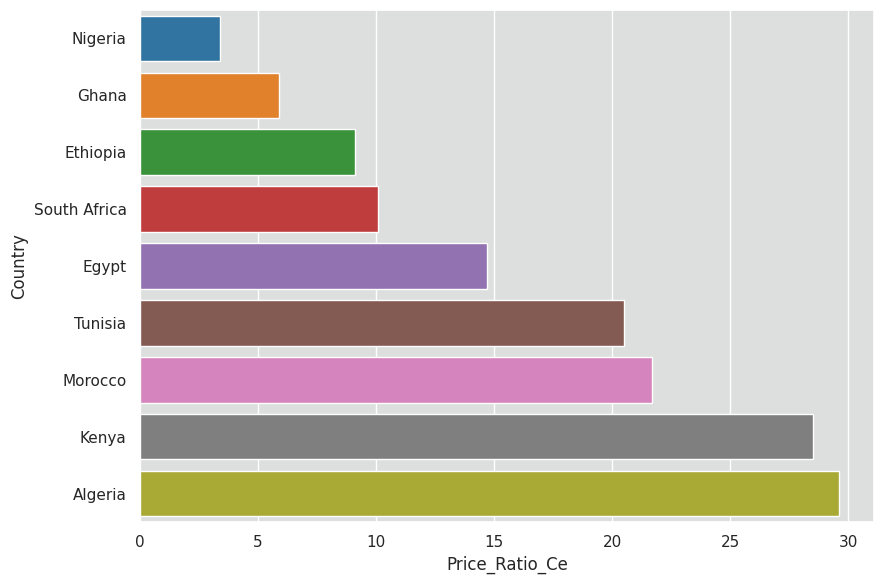

In [ ]:
sns.barplot(
    df_africa,
    x = 'Price_Ratio_Ce',
    y = 'Country',
    order = df_africa.sort_values('Price_Ratio_Ce', ascending=True).Country
)
plt.tight_layout()

# Buy Inside and outside of the city

## Asia

In [ ]:
centro = df_asia.sort_values('Price_Ratio_Ce', ascending=True).head(5)
fuera = df_asia.sort_values('Price_Ratio_Out', ascending=True).head(5)

centro[centro.isin(fuera)].dropna()

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affortability,Continente,Gross_Different,Price_Ratio_Different
106,United Arab Emirates,3.0,12.2,10.4,8.2,9.6,20.8,4.8,Asia,1.8,-1.4
43,Georgia,13.3,10.0,12.1,10.0,8.3,177.4,0.6,Asia,-2.1,1.7
96,Cyprus,6.8,9.4,10.2,10.7,9.8,44.2,2.3,Asia,-0.8,0.9


## America

In [ ]:
centro = df_america.sort_values('Price_Ratio_Ce', ascending=True).head(10)
fuera = df_america.sort_values('Price_Ratio_Out', ascending=True).head(10)

centro[centro.isin(fuera)].dropna()

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affortability,Continente,Gross_Different,Price_Ratio_Different
101,Puerto Rico,4.5,10.9,9.4,9.2,10.6,34.8,2.9,America,1.5,-1.4
72,Panama,10.2,9.1,8.1,11.0,12.3,86.9,1.2,America,1.0,-1.3
102,United States,4.5,8.2,9.6,12.2,10.4,36.4,2.8,America,-1.4,1.8
58,Guatemala,11.9,7.9,8.2,12.6,12.3,121.4,0.8,America,-0.3,0.3
17,Venezuela,18.9,7.9,6.2,12.6,16.2,471.6,0.2,America,1.7,-3.6
28,Dominican Republic,15.8,7.9,5.5,12.7,18.2,210.0,0.5,America,2.4,-5.5
83,Mexico,8.4,7.8,7.4,12.7,13.5,104.6,1.0,America,0.4,-0.8
82,Honduras,8.9,7.4,5.8,13.4,17.3,117.7,0.8,America,1.6,-3.9
77,Costa Rica,9.5,6.5,6.6,15.3,15.3,106.6,0.9,America,-0.1,0.0


## Europa

In [ ]:
centro = df_europe.sort_values('Price_Ratio_Ce', ascending=True).head(10)
fuera = df_europe.sort_values('Price_Ratio_Out', ascending=True).head(10)

centro[centro.isin(fuera)].dropna()

,Country,Price_to_Income,Gross_Rental_Ce,Gross_Rental_Out,Price_Ratio_Ce,Price_Ratio_Out,Mortgage_As_Percentage,Affortability,Continente,Gross_Different,Price_Ratio_Different
93,Ireland,7.3,6.8,8.1,14.7,12.3,50.2,2.0,Europe,-1.3,2.4
53,Ukraine,12.2,5.8,5.9,17.3,17.1,194.1,0.5,Europe,-0.1,0.2
51,Portugal,12.6,5.4,6.0,18.4,16.7,78.0,1.3,Europe,-0.6,1.7
95,Iceland,7.0,5.4,6.0,18.6,16.5,57.1,1.8,Europe,-0.6,2.1
54,Moldova,12.1,5.3,6.1,18.7,16.3,139.6,0.7,Europe,-0.8,2.4
56,Malta,12.1,5.3,5.6,18.8,18.0,88.7,1.1,Europe,-0.3,0.8
90,Spain,7.8,4.8,6.2,20.7,16.2,48.5,2.1,Europe,-1.4,4.5


# Rentar Fuera de la ciudad

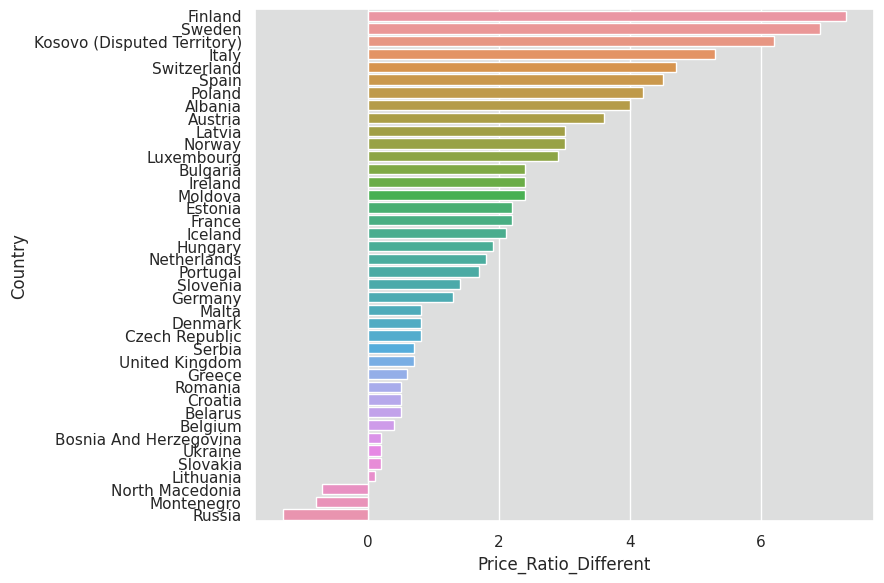

In [ ]:
fig, ax = plt.subplots()

sns.barplot(
    data = df_europe,
    y = 'Country',
    x = 'Price_Ratio_Different',
    order = df_europe.sort_values('Price_Ratio_Different', ascending = False).Country,
    ax = ax
)

#ax.set_yticklabels(ax.get_yticklabels(), rotation=45, horizontalalignment='right')
plt.tight_layout()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3aa0e2c3-1d5b-4b17-bb31-7a3c04c89158' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>